# Sentiment and topic analysis on tweets about Groningen

### Import modules

In [39]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import torch.nn.functional as F
import numpy as np
from scipy.special import softmax
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pyLDAvis.enable_notebook()
from transformers import pipeline
import spacy
from spacy.lang.nl.examples import sentences 
from time import sleep
from deep_translator import GoogleTranslator
from matplotlib.colors import LinearSegmentedColormap

[nltk_data] Downloading package punkt to /home/aron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
# Preprocess text (username and link placeholders)
def preprocess_mentions_links(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

### Instantiate model and tokenizer

In [41]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Testing a simple sentence

In [42]:
text = "Covid cases are increasing fast!"
text = preprocess_mentions_links(text)
encoded_input = tokenizer(text, return_tensors='pt')

output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [43]:
ranking = np.argsort(scores)
ranking = ranking[::-1]

for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


### Loading and preprocessing the data

In [44]:
data = pd.concat([pd.read_csv(file) for file in ["data/data collection 1/Twitter Search Results Scraper (1)_20240421_1743.csv",
                                                 "data/data collection 1/Twitter Search Results Scraper (1)_20240430_0911.csv",
                                                 "data/data collection 1/Twitter Search Results Scraper (1)_20240430_1210.csv",
                                                 "data/data collection 1/Twitter Search Results Scraper (1)_20240430_1243.csv",
                                                 "data/data collection 1/Twitter Search Results Scraper (1)_20240501_0006.csv",
                                                 "data/Twitter Search Results Scraper (1)_20240501_0939.csv"]],
                 ignore_index=True).drop_duplicates(subset='content')
tweets_raw = data['content']

In [45]:
# Sort the data by 'likes' column in descending order
sorted_data = data.sort_values(by='likes', ascending=False)

# Extract the content of the most liked tweets
most_liked_tweets = sorted_data['content'].head(10).tolist()

# Print the list of the most liked tweets
print("Top 10 most liked tweets:")
for index, tweet in enumerate(most_liked_tweets, 1):
    print(f"{index}. {tweet}")

Top 10 most liked tweets:
1. 29 April 1934 | Dutch Jewish girl, Lea Davids, was born in Groningen.  She was transferred from #Westerbork to #Theresienstadt ghetto on 6 September 1944. She was deported to #Auschwitz from there on 4 October 1944. She was murdered in a gas chamber after arrival selection. https://t.co/h1D8KhSMfR
2. Groningen, Netherlands 🇳🇱 https://t.co/sZlQYycG06
3. Etienne Riejnen is also joining LFC as technical analyst &amp; advisor to Arne Slot. Both of them used to be teammates at PEC Zwolle as players. Riejnen as a player was a CB who played in various clubs like Groningen, where Virgil van Dijk made his professional debut. https://t.co/9XeQkpcd0p
4. De geschiedenis gaat heel zwaar oordelen over deze waanzin. Een historische fout. #Groningen #gaskraan
5. Ons land overspoeld met migranten, de corona-periode, Groningen, toeslagen-misdaad, boeren &amp; vissers KAPOT! Rutte verdient geen baan bij de NAVO maar een CELSTRAF!   Doe een ♥️ &amp; RT als je het eens bent! ht

In [46]:
data.describe()

,id,result_position,bookmarks_count,binded_media_url,binded_media_domain,binded_media_thumbnail_url,binded_media_title,binded_media_description,internal_unique_id,likes,original_tweet_id,quote_count,retweet_count,reply_count,user_id,views_count
count,1002.000000,1002.000000,1002.000000,0.0,0.0,0.0,0.0,0.0,1.002000e+03,1002.000000,9.900000e+01,1002.000000,1002.000000,1002.000000,1.002000e+03,9.990000e+02
mean,40601.300399,166.829341,0.905190,NaN,NaN,NaN,NaN,NaN,1.782788e+18,36.057884,1.769657e+18,0.522954,7.504990,3.065868,5.511724e+17,1.796308e+04
std,7621.412022,108.504160,5.954371,NaN,NaN,NaN,NaN,NaN,3.222766e+15,238.732297,8.902360e+16,2.559184,52.997488,11.876641,6.860682e+17,1.576719e+05
min,29630.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.725426e+18,0.000000,9.554763e+17,0.000000,0.000000,0.000000,2.433331e+06,1.000000e+00
25%,29880.250000,73.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.781329e+18,0.000000,1.781058e+18,0.000000,0.000000,0.000000,2.337195e+08,6.000000e+01
50%,45798.500000,153.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.783178e+18,3.000000,1.782938e+18,0.000000,0.000000,0.000000,2.343982e+09,1.920000e+02
75%,46042.750000,254.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.784564e+18,13.000000,1.783907e+18,0.000000,2.000000,2.000000,1.253119e+18,1.107500e+03
max,46599.000000,402.000000,104.000000,NaN,NaN,NaN,NaN,NaN,1.785605e+18,6573.000000,1.785601e+18,57.000000,1468.000000,191.000000,1.775606e+18,3.780507e+06


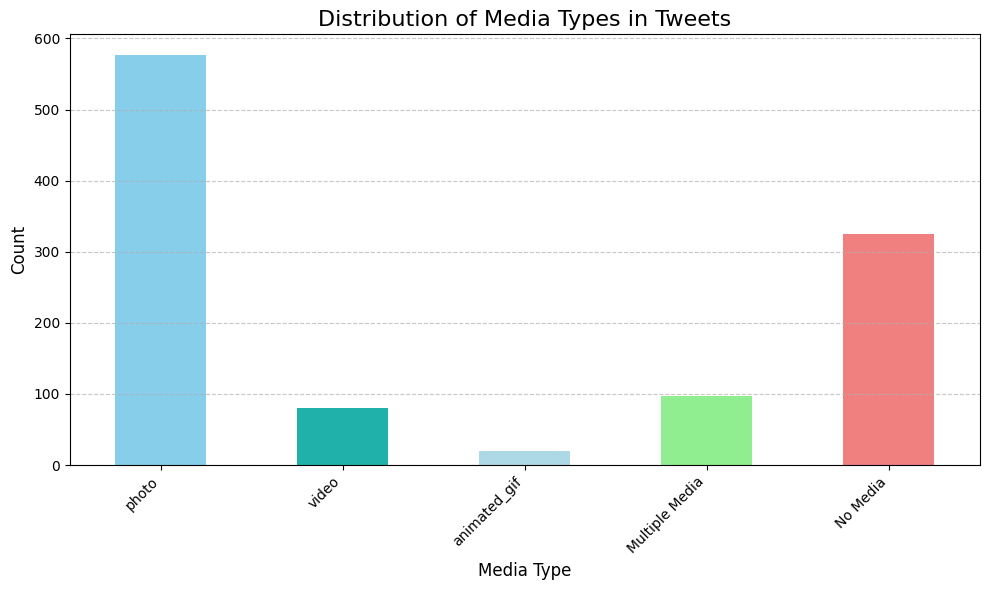

<Figure size 640x480 with 0 Axes>

In [47]:
# List of media columns
media_columns = ['media_0_type', 'media_1_type', 'media_2_type', 'media_3_type']

# Combine media types from all columns into a single Series
all_media_types = pd.concat([data[col] for col in media_columns], ignore_index=True)

# Count the occurrences of each media type
media_counts = all_media_types.value_counts()

# Count the number of tweets with multiple media types
multiple_media_count = (data[media_columns].count(axis=1) > 1).sum()

# Add the count of tweets with multiple media types to the media_counts Series
media_counts['Multiple Media'] = multiple_media_count

# Count the number of tweets without any media
no_media_count = len(data) - all_media_types.count()

# Add the count of tweets without any media to the media_counts Series
media_counts['No Media'] = no_media_count

# Set colors for different media types
colors = ['skyblue'] * len(media_counts)
colors[-1] = 'lightcoral'  # Color for "No Media"
colors[-2] = 'lightgreen'  # Color for "Multiple Media"
colors[-2] = 'lightgreen'  # Color for "Multiple Media"
colors[-3] = 'lightblue'  # Color for "Multiple Media"
colors[-4] = 'lightseagreen'  # Color for "Multiple Media"

# Plot the media type distribution
plt.figure(figsize=(10, 6))
media_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Media Types in Tweets', fontsize=16)
plt.xlabel('Media Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('/home/aron/projects/nlp_sentiment/graphs/distribution_media')

<Figure size 1000x600 with 0 Axes>

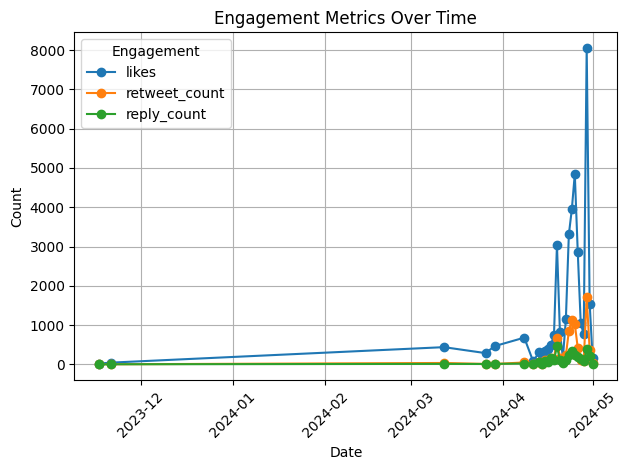

In [48]:
# Convert the 'published_at' column to datetime format
data['published_at'] = pd.to_datetime(data['published_at'])

# Group the data by date and calculate sum of likes, retweets, and replies for each date
engagement_over_time = data.groupby(data['published_at'].dt.date)[['likes', 'retweet_count', 'reply_count']].sum()

# Plot the engagement metrics over time
plt.figure(figsize=(10, 6))
engagement_over_time.plot(marker='o')
plt.title('Engagement Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Engagement')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

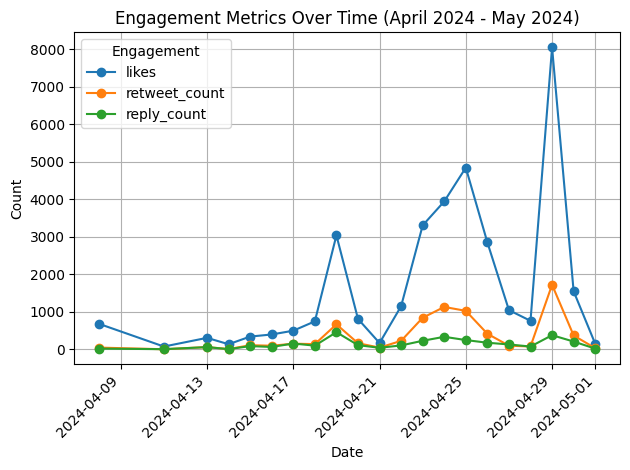

In [49]:
# Convert the index to datetime format
engagement_over_time.index = pd.to_datetime(engagement_over_time.index)

# Filter the engagement data for the desired time period (from February 2024 to May 2024)
engagement_zoomed = engagement_over_time.loc['2024-04-01':'2024-05-31']

# Plot the engagement metrics over time for the zoomed-in period
plt.figure(figsize=(10, 6))
engagement_zoomed.plot(marker='o')
plt.title('Engagement Metrics Over Time (April 2024 - May 2024)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Engagement')
plt.tight_layout()
plt.show()

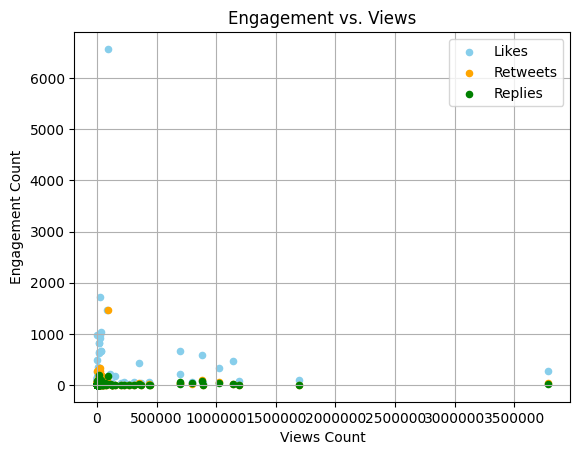

In [50]:
# Plot 4: Engagement vs. Views
data.plot(kind='scatter', x='views_count', y='likes', color='skyblue', label='Likes', ax=plt.gca())
data.plot(kind='scatter', x='views_count', y='retweet_count', color='orange', label='Retweets', ax=plt.gca())
data.plot(kind='scatter', x='views_count', y='reply_count', color='green', label='Replies', ax=plt.gca())

# Adjust x-axis tick labels
plt.ticklabel_format(style='plain', axis='x')

plt.title('Engagement vs. Views')
plt.xlabel('Views Count')
plt.ylabel('Engagement Count')
plt.grid(True)
plt.legend()

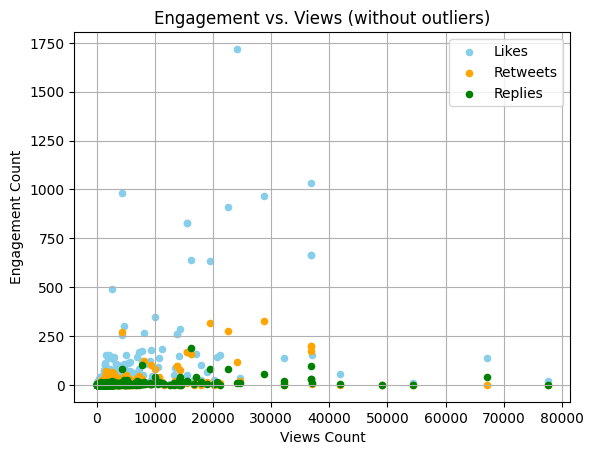

In [51]:
# Calculate mean and standard deviation for views_count
mean_views = data['views_count'].mean()
std_views = data['views_count'].std()

# Define a threshold for outliers (e.g., 3 standard deviations from the mean)
threshold = 0.4

# Filter data to remove outliers
filtered_data = data[(data['views_count'] >= mean_views - threshold * std_views) & (data['views_count'] <= mean_views + threshold * std_views)]

# Plot filtered data
scatter1 = filtered_data.plot(kind='scatter', x='views_count', y='likes', color='skyblue', label='Likes')
scatter2 = filtered_data.plot(kind='scatter', x='views_count', y='retweet_count', color='orange', label='Retweets', ax=scatter1)
scatter3 = filtered_data.plot(kind='scatter', x='views_count', y='reply_count', color='green', label='Replies', ax=scatter1)

plt.title('Engagement vs. Views (without outliers)')
plt.xlabel('Views Count')
plt.ylabel('Engagement Count')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
#First remove mentions and links and replace with placeholders
data['tweets_with_placeholders'] = tweets_raw.apply(preprocess_mentions_links)

# Preprocess the tweets
data['preprocessed_text'] = data['content'].apply(preprocess_mentions_links)

In [53]:
data['tweets_with_placeholders']

0       Nog een vraag ...mag ik hier fietsen? #reitdie...
1       “Hoe leg ik dit uit aan mijn kind?”  Hekken om...
2       Senator @user on fire over arrogante houding v...
3       Mooi om te zien. In de laatste jaren Eredivisi...
4       De geschiedenis gaat heel zwaar oordelen over ...
                              ...                        
2094    http Der preis vom kleinsten Gewitter geht an das
2095    VI (28okt2002): Voor FC Groningen, waar Lodewe...
2096    Welcome to BBT and to #Groningen! Good luck wi...
2097    Welke Goddess wil haar leren vieze Koningsdag ...
2098    And another one! Altered plasma levels and tis...
Name: tweets_with_placeholders, Length: 1002, dtype: object

In [54]:
#Remove special characters, convert to lower case and strip whitespace (keep placeholders for now)

def clean_text(text):
    # Remove special characters and placeholders
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # Remove 'http'
    text = text.replace('http', '')
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove trailing whitespace
    text = text.strip()
    
    return text

# Example usage:
text = "This is a sample tweet with @user and http links! #example"
cleaned_text = clean_text(text)
print(cleaned_text) 

this is a sample tweet with user and  links example


In [55]:
#apply this preprocessing step on the tweets (overwrite data['preprocessed_text'])

data['preprocessed_text'] = data['preprocessed_text'].apply(clean_text)
data['preprocessed_text']

0       nog een vraag mag ik hier fietsen reitdiephave...
1       hoe leg ik dit uit aan mijn kind  hekken om je...
2       senator user on fire over arrogante houding va...
3       mooi om te zien in de laatste jaren eredivisie...
4       de geschiedenis gaat heel zwaar oordelen over ...
                              ...                        
2094         der preis vom kleinsten gewitter geht an das
2095    vi 28okt2002 voor fc groningen waar lodeweges ...
2096    welcome to bbt and to groningen good luck with...
2097    welke goddess wil haar leren vieze koningsdag ...
2098    and another one altered plasma levels and tiss...
Name: preprocessed_text, Length: 1002, dtype: object

## Translating the content column to english

### Bulk approach

In [56]:
# Function to translate text to English
def translate_to_english(text):
    try:
        translated_text = GoogleTranslator(source='auto', target='en').translate(text)
        return translated_text
    except Exception as e:
        print(f"Error translating text: {text}")
        print(f"Error message: {str(e)}")
        return None

# Translate each text in the column individually
data['translated_cleaned_text'] = data['preprocessed_text'].apply(translate_to_english)

# Print the translated texts
print(data['translated_cleaned_text'])


0       one more question, can I cycle here at Reitdie...
1       how do I explain this to my child, fences arou...
2       senator user on fire about arrogant attitude o...
3       nice to see in recent years the premier league...
4       History is going to judge this madness very he...
                              ...                        
2094    The prize for the smallest thunderstorm goes t...
2095    vi 28oct2002 for fc groningen where lodeweges ...
2096    welcome to bbt and to groningen good luck with...
2097    Which goddess wants to teach her to have her d...
2098    and another one altered plasma levels and tiss...
Name: translated_cleaned_text, Length: 1002, dtype: object


In [57]:
def perform_sentiment_analysis(text):
    # Tokenize the text
    encoded_input = tokenizer(text, return_tensors='pt')
    
    # Get model output
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    # Get sentiment label
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    label = config.id2label[ranking[0]]
    
    return label, scores

# Apply sentiment analysis to the 'translated_cleaned_text' column
data['sentiment'], data['sentiment_score'] = zip(*data['translated_cleaned_text'].apply(perform_sentiment_analysis))

# Display the updated DataFrame columns
print(data[['sentiment', 'sentiment_score']])

     sentiment                        sentiment_score
0      neutral   [0.014564315, 0.9513248, 0.03411099]
1     negative  [0.81083244, 0.17725414, 0.011913373]
2     negative    [0.708958, 0.27858803, 0.012453997]
3     positive   [0.008967502, 0.09866722, 0.8923652]
4     negative   [0.9189497, 0.07543753, 0.005612789]
...        ...                                    ...
2094   neutral   [0.09216867, 0.68903035, 0.21880102]
2095   neutral   [0.22271018, 0.7444846, 0.032805286]
2096  positive  [0.0044116504, 0.07851744, 0.9170709]
2097   neutral    [0.15212472, 0.6848552, 0.16302004]
2098   neutral   [0.10213232, 0.8705569, 0.027310774]

[1002 rows x 2 columns]


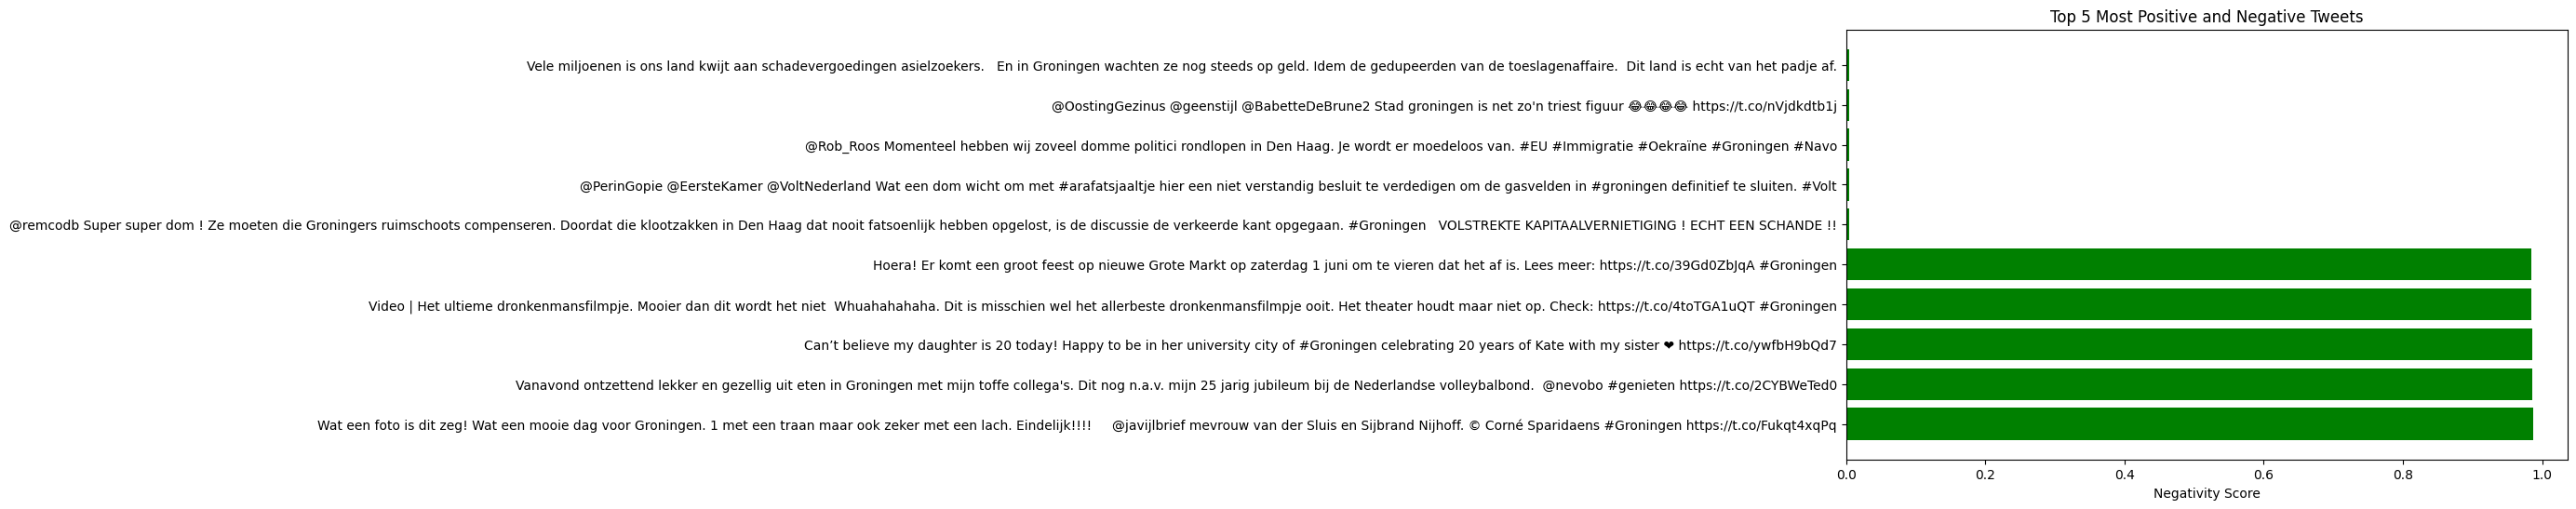

In [62]:
# Find the most positive and negative tweets
most_positive_tweets = data.sort_values(by='negativity', ascending=False).head(5)
most_negative_tweets = data.sort_values(by='negativity').head(5)

# Combine the positive and negative tweets
combined_tweets = pd.concat([most_positive_tweets, most_negative_tweets])

# Create a bar plot
plt.figure(figsize=(10, 6))
colors = ['green' if sentiment_score > 0 else 'red' for sentiment_score in combined_tweets['negativity']]
plt.barh(combined_tweets['content'], combined_tweets['negativity'], color=colors)
plt.xlabel('Negativity Score')
plt.title('Top 5 Most Positive and Negative Tweets')
plt.show()

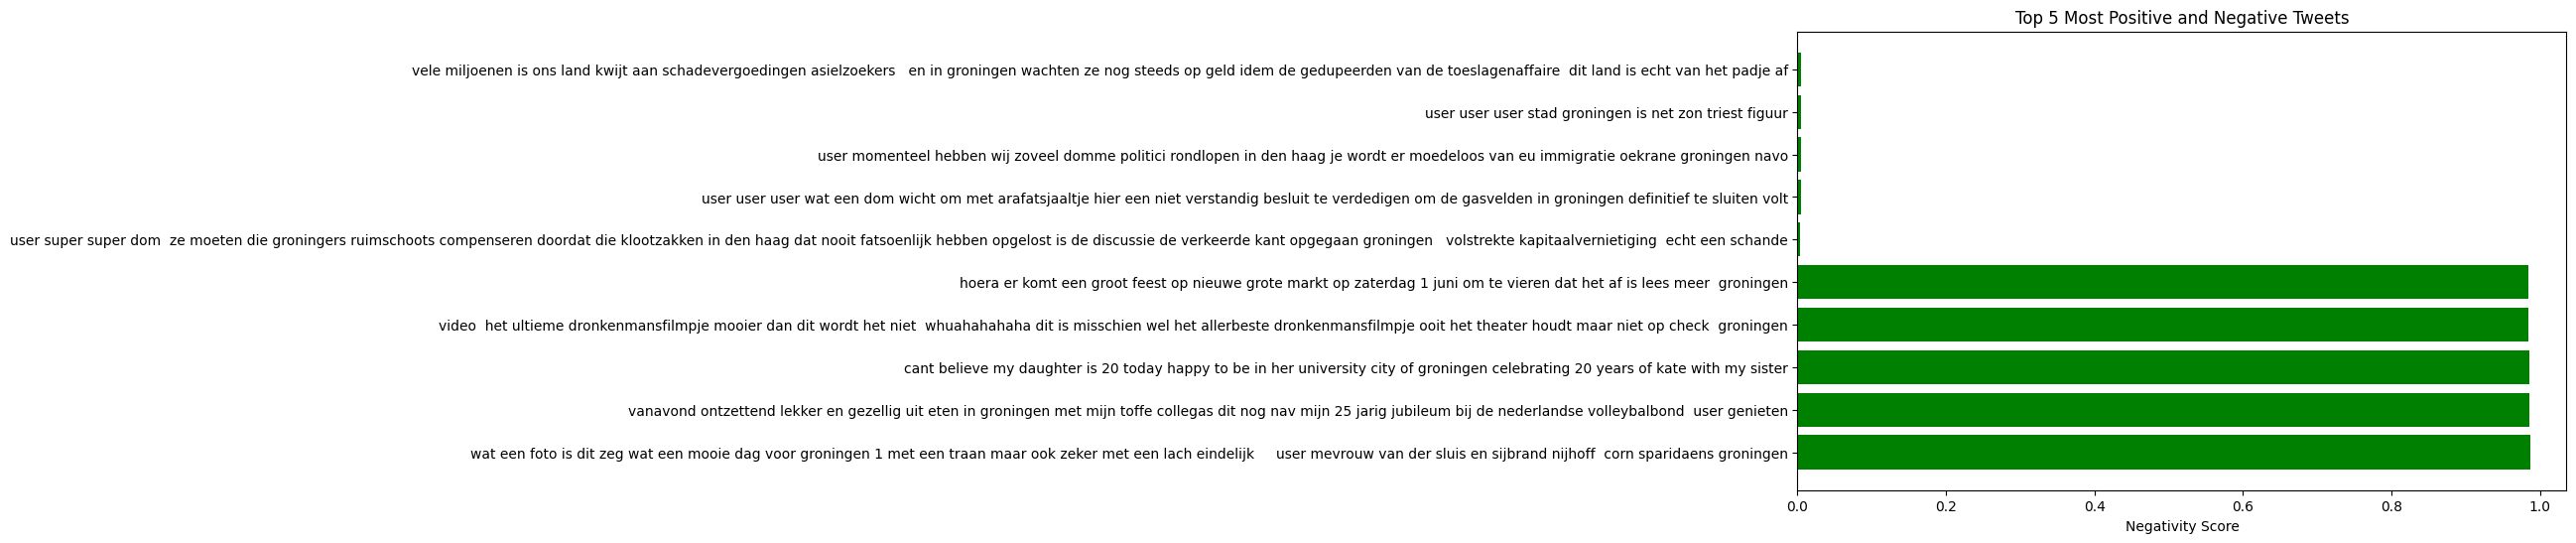

In [63]:
# Find the most positive and negative tweets
most_positive_tweets = data.sort_values(by='negativity', ascending=False).head(5)
most_negative_tweets = data.sort_values(by='negativity').head(5)

# Combine the positive and negative tweets
combined_tweets = pd.concat([most_positive_tweets, most_negative_tweets])

# Create a bar plot
plt.figure(figsize=(10, 6))
colors = ['green' if sentiment_score > 0 else 'red' for sentiment_score in combined_tweets['negativity']]
plt.barh(combined_tweets['preprocessed_text'], combined_tweets['negativity'], color=colors)
plt.xlabel('Negativity Score')
plt.title('Top 5 Most Positive and Negative Tweets')
plt.show()

In [64]:
# Convert the sentiment scores to a numerical value representing negativity
data['negativity'] = data['sentiment_score'].apply(lambda x: x[2])

# Find the most negative tweet
most_negative_tweet = data[data['negativity'] == data['negativity'].min()]['translated_cleaned_text'].iloc[0:5]

print("Most negative Tweet:")
print(most_negative_tweet)

Most negative Tweet:
179    user super super stupid they have to amply com...
Name: translated_cleaned_text, dtype: object


In [65]:
# Convert the sentiment scores to a numerical value representing positivity
data['positivity'] = data['sentiment_score'].apply(lambda x: x[0])

# Find the most positive tweet
most_positive_tweet = data[data['positivity'] == data['positivity'].min()]['translated_cleaned_text'].iloc[0]

print("Most positive Tweet:")
print(most_positive_tweet)


Most positive Tweet:
Hooray there will be a big party at the new large market on Saturday June 1 to celebrate the completion read more Groningen


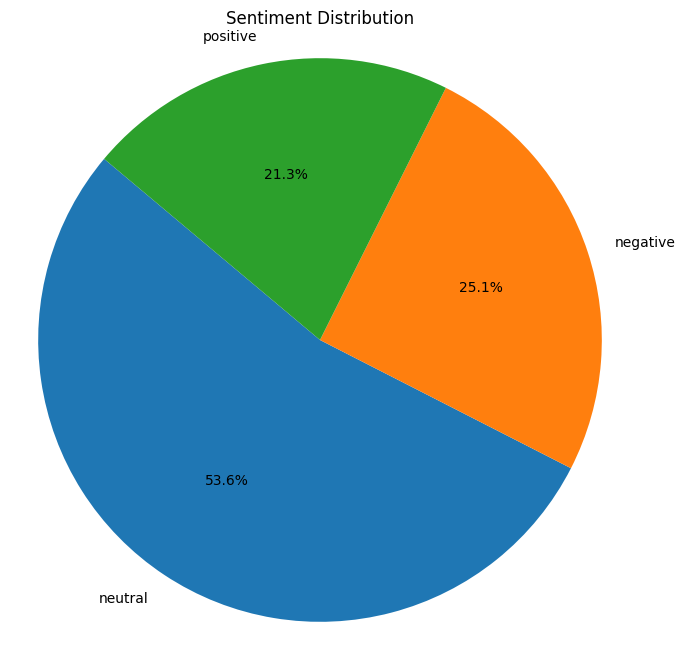

In [66]:
data['sentiment'].value_counts()

# Data
sentiment_counts = data['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

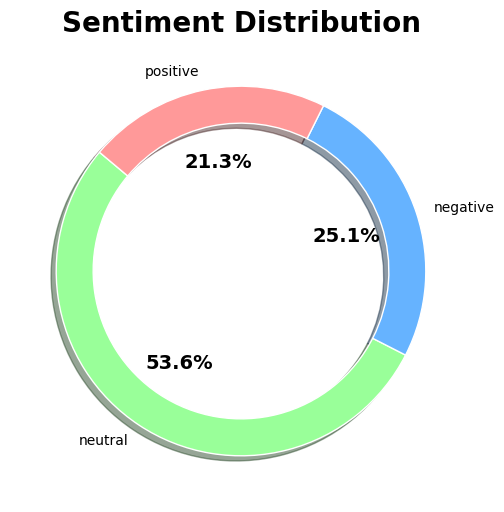

In [67]:
# Define custom gradient colors
colors = ['#99ff99', '#66b3ff', '#ff9999']  # Green for positive, Blue for neutral, Red for negative
cmap = LinearSegmentedColormap.from_list('custom_gradient', colors, N=len(sentiment_counts))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140,
                                   colors=cmap(np.arange(len(sentiment_counts))), shadow=True, wedgeprops=dict(width=0.2))

# Add 3D effect
for wedge in wedges:
    wedge.set_edgecolor('white')

# Customize text properties
plt.setp(autotexts, size=14, weight="bold")

# Add title
plt.title('Sentiment Distribution', fontsize=20, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.set_aspect('equal')

# Remove axes
ax.axis('off')

# Show plot
plt.show()


In [68]:
# Filter the DataFrame for positive sentiment
positive_tweets = data[data['sentiment'] == 'positive']

# Print all positive tweets
for index, row in positive_tweets.iterrows():
    print(row['translated_cleaned_text'])


nice to see in recent years the premier league many empty seats at groningen this year kkd and the stadium is nice and full it started to liven up for us when we played football for a year lower and look where we are now and how the region lives grocam fctwente
The fact that the gas tap is now closed is due to the tireless efforts of many normal invisible people. I see a lot of chest beating while nothing would have been achieved without these invisible people. That is why you have achieved this together with these lovely people. Groningen peoplepower
a photo a day keeps my freedom close 21042024 yesterday photography photo photo photography photojournalism stories story stories personal personal passion passion architecture moma aduard westerkwartier groningen
today the flag will be raised tomorrow action Groningen success has many fathers but this success belongs to Groningen people themselves years of struggle against the state lies destructiveness contempt this is now ours because 

In [69]:
# Filter the DataFrame for positive sentiment
positive_tweets = data[data['sentiment'] == 'negative']

# Print all positive tweets
for index, row in positive_tweets.iterrows():
    print(row['translated_cleaned_text'])

how do I explain this to my child, fences around your apartment are cracked everywhere because of insecurity, but you have to explain to your child that you don't know if and when something will be done, the madness of Groningen, that's why we took action yesterday with the flame oven apartment, this has to be solved
senator user on fire about arrogant attitude of user towards user about termination of gas extraction in Groningen Van Rooijen is the only one who wants a rational approach and does not allow himself to be held hostage by the emomafia in the Netherlands media amp politics that do everything based on emotion
History is going to judge this madness very heavily, a historical error Groningen gas tap
never throw away your old shoes before you have new ones Groningen stupid concrete layer of 500 meters ensures that the gas tap in Groningen will never open again
about henk kamp facts that the editors of user do not have ready about gas extraction in Groningen he sacrificed the sa

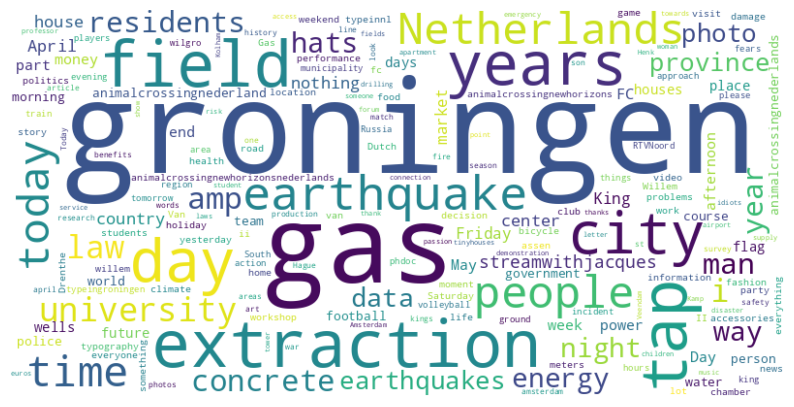

In [70]:
# Create TextBlob objects for each preprocessed tweet
data['textblob'] = data['translated_cleaned_text'].apply(TextBlob)

# Extract nouns from each tweet and flatten the list
nouns = [word for blob in data['textblob'] for word, pos in blob.tags if pos.startswith('N')]

# Count occurrences of each noun
noun_counts = Counter(nouns)

if "Groningen" in noun_counts:
    del noun_counts["Groningen"]

if "netherlands" in noun_counts:
    del noun_counts["netherlands"]

if "user" in noun_counts:
    del noun_counts["user"]

if "User" in noun_counts:
    del noun_counts["User"]

# Visualize the results using a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Topic analysis

In [71]:
#Preprocessing for LDA

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenization, stopwords removal, and lemmatization function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]
    return processed_tokens

# Apply preprocessing to each document in the 'translated_cleaned_text' column
processed_texts = [preprocess_text(text) for text in data['translated_cleaned_text']]

In [72]:
# Load the English NER model
nlp = spacy.load("en_core_web_sm")

# Example English tweets column
tweets = data['translated_cleaned_text']

# Initialize a dictionary to store named entities and their labels
all_entities = {}

# Iterate over each tweet and apply NER
for tweet in tweets:
    # Apply NER to the tweet
    doc = nlp(tweet)
    
    # Aggregate named entities and their labels
    for ent in doc.ents:
        all_entities.setdefault(ent.text, set()).add(ent.label_)

# Print the named entities and their labels
for entity, labels in all_entities.items():
    print(f"Entity: {entity}, Labels: {', '.join(labels)}")

Entity: one, Labels: CARDINAL
Entity: Reitdiephaven Groningen, Labels: PERSON
Entity: Groningen, Labels: GPE, PERSON, ORG
Entity: yesterday, Labels: DATE
Entity: Groningen Van Rooijen, Labels: FAC
Entity: Netherlands, Labels: GPE
Entity: recent years, Labels: DATE
Entity: this year, Labels: DATE
Entity: a year, Labels: DATE
Entity: next year, Labels: DATE
Entity: 500 meters, Labels: QUANTITY
Entity: the day, Labels: DATE
Entity: Henk Kamp, Labels: PERSON
Entity: VVDER, Labels: NORP
Entity: a day, Labels: DATE
Entity: Kamp, Labels: ORG
Entity: Gasberaad, Labels: PERSON
Entity: 21042024, Labels: DATE
Entity: Amsterdam, Labels: GPE
Entity: 46 million, Labels: CARDINAL
Entity: today, Labels: DATE
Entity: tomorrow, Labels: DATE
Entity: 1213,000, Labels: CARDINAL
Entity: 78 cents, Labels: MONEY
Entity: Tomorrow, Labels: DATE
Entity: Rebellion Groningen, Labels: PERSON
Entity: 1215, Labels: DATE
Entity: Eelde Airport, Labels: FAC
Entity: 1, Labels: CARDINAL
Entity: May 5, Labels: DATE
Entity:

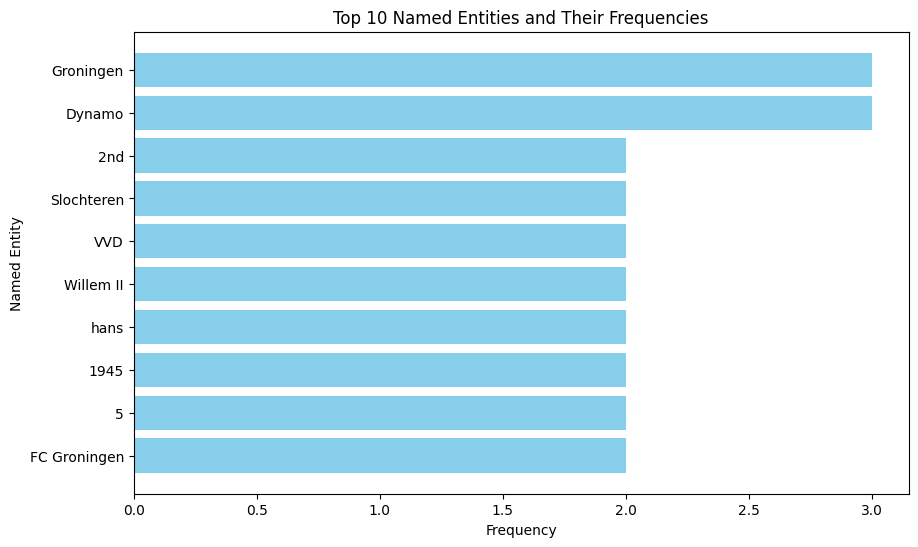

In [73]:
# Count the frequency of each named entity and its labels
entity_counts = {}
for entity, labels in all_entities.items():
    entity_counts[entity] = len(labels)

# Sort the entities by frequency
sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top N entities and their frequencies
top_entities = [entity[0] for entity in sorted_entities[:10]]
entity_frequencies = [entity[1] for entity in sorted_entities[:10]]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_entities, entity_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Named Entity')
plt.title('Top 10 Named Entities and Their Frequencies')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent entities at the top
plt.show()